# Parameterization for sediment released by sea-ice

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
import glob
import datetime as dt
import pickle
import scipy.ndimage as ndimage

%matplotlib notebook

In [3]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

In [4]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])
land_mask = np.ma.masked_where((tmask[0,:,:,:] > 0.1), tmask[0,:,:,:])

mesh     = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
mesh_lon = np.array(mesh.variables['nav_lon'])
mesh_lat = np.array(mesh.variables['nav_lat'])

In [5]:
def load_tracks(filename):
    nemo_file  = nc.Dataset(filename)

    traj = np.array(nemo_file.variables['trajectory']) # dimensions: number of particles, tracks
    time = np.array(nemo_file.variables['time'])       # units: seconds
    lat  = np.array(nemo_file.variables['lat'])        # degrees North
    lon  = np.array(nemo_file.variables['lon'])        # degrees East

    return traj, time, lon, lat

In [6]:
def check_laptev(CB_traj, CB_lon, CB_lat, CB_time):
    # does the parcel spend time in the laptev sea in the fall?

    # Define boundary latitudes and longitudes for the Laptev Sea region
    trajS_bdy1 = 68
    trajN_bdy1 = 74
    trajE_bdy1 = -170
    trajW_bdy1 = -210

    trajS_bdy2 = 70
    trajN_bdy2 = 75
    trajE_bdy2 = -185
    trajW_bdy2 = -230
    
    Laptev_particle = False
    # At each time step:
    for timestep in range(0,len(CB_traj)):
        if ((CB_lon[timestep]   < trajE_bdy1) & (CB_lon[timestep] > trajW_bdy1) \
            & (CB_lat[timestep] < trajN_bdy1) & (CB_lat[timestep] > trajS_bdy1)) or \
           ((CB_lon[timestep]   < trajE_bdy2) & (CB_lon[timestep] > trajW_bdy2) \
            & (CB_lat[timestep] < trajN_bdy2) & (CB_lat[timestep] > trajS_bdy2)):

            start_time   = dt.datetime(2015,12,31) - dt.timedelta(seconds=CB_time[0])
            current_time = start_time - dt.timedelta(seconds=CB_time[timestep])

            # And is the parcel on the shelf in the fall?
            if current_time.month in [9,10,11,12]:
                Laptev_particle = True
                break
                    
    return Laptev_particle

In [7]:
def parcel_origin(CB_lon, CB_lat, CB_time, CB_traj):

    dim_parc = int((CB_lon.shape[0]/12)/np.ceil(CB_lon.shape[1]/(4*365))) # bottom converts 6 hour to days    
    dim_time = int(12*((CB_lon.shape[0]/dim_parc)/12))

    particles_origin = np.zeros((dim_parc,dim_time))
    # --- Russian shelf in fall = 1
    # --- else = 0

    for release_time in range(0,dim_time):
        for location in range(0,dim_parc):
            ind = location + release_time*dim_parc
            lon_loc = CB_lon[ind,:]
            lat_loc = CB_lat[ind,:]
            time_loc = CB_time[ind,:]
            traj_loc = CB_traj[ind,:]

            Laptev_particle = check_laptev(traj_loc, lon_loc, lat_loc, time_loc)

            if Laptev_particle:
                particles_origin[location, release_time] = 1

    return particles_origin

In [8]:
def interp_np(nav_lon, nav_lat, var_in, lon_ANHA12, lat_ANHA12):
    ''' Interpolate some field to ANHA12 grid.
        The function is based on the bilinear interpolation in scipy, griddata 
        =======================================================================
            nav_lon, nav_lat        : input field lon/lat
            lon_ANHA12, lat_ANHA12  : ANHA12 defined lons/lats
            var_in                  : 2-D model variable
    '''
    from scipy.interpolate import griddata
    LatLonPair = (nav_lon, nav_lat)
    var_out = griddata(LatLonPair, var_in, (lon_ANHA12, lat_ANHA12), method='cubic')
    # Take nearest neighbour interpolation to fill nans
    var_fill = griddata(LatLonPair, var_in, (lon_ANHA12, lat_ANHA12), method='nearest')
    
    # fill nans with constant value (0.1)
    var_out[np.isnan(var_out)] = var_fill[np.isnan(var_out)]
    return var_out

Parameterization components:

1) Ice melt:
    - if (ice production < 0) --> ice is melting 
    - units of ice melt, iiceprod, are in m/kt (180 s timestep)
        - convert m/kt to m/s
        - multiply iiceprod by the grid box area to get a volume of melt
2) Sediment forcing
    - sediment content forcing field: units of grams of sediment / m3 of ice
        - background sediment content amount (include higher on shelf regions)
        - Laptev Sea sediment amounts
    - multiply forcing field by sediment content 
    - multiply sediment forcing field by ice melt (m3) to get grams of sediment
    - add sediment to surface grid box + solubility, Mn content

Parameterization equation:

\begin{equation}
\frac{\partial dMn}{\partial t} = \frac{\alpha \cdot P_{Siberian} \cdot S_{content} \cdot f_{Mn,sed}}{m} \frac{I_{prod}}{180} \cdot \frac{A_{cell}}{V_{cell}} \cdot \frac{1}{1000.0}
\end{equation}

where $P_{Siberian}$ is the proportion of Siberian shelf origin influence, and $S_{content}$ is the amount of sediment in ice from Siberian shelf regions

double-check the units:

\begin{equation}
\frac{\partial dMn}{\partial t} = \frac{(g_{sed}/m^3)(g_{Mn}/kg_{sed})}{g_{Mn}/mol} \frac{m/kt}{s/kt} \cdot m^2 \cdot \frac{1 kg}{1000 g} = \frac{mol}{s}
\end{equation}
should be mol/L/s right?

simplifies to:

\begin{equation}
\frac{\partial dMn}{\partial t} = \frac{\alpha \cdot P_{Siberian} \cdot S_{content} \cdot f_{Mn,sed}}{m \cdot \Delta z_{surface}} \frac{I_{prod}}{180} \cdot \frac{1}{1000.0} \cdot \frac{1}{1000.0}
\end{equation}

\begin{equation}
\frac{\partial dMn}{\partial t} = \frac{() \cdot () \cdot (g_{sed}/m^3)(g_{Mn}/kg_{sed})}{(g_{Mn}/mol)(m)} \frac{m/kt}{s/kt} \cdot \frac{1 kg}{1000 g} \cdot \frac{1 m^3}{1000 L} = \frac{mol}{s \cdot L}
\end{equation}

In [9]:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(117/N, 1, N)
vals_cont[:, 1] = np.linspace(82/N, 1, N)
vals_cont[:, 2] = np.linspace(60/N, 1, N)
sed_cmap = matplotlib.colors.ListedColormap(vals_cont).reversed()

### (2) Sediment forcing field

Load parcel trajectories

In [10]:
CB_traj, CB_time, CB_lon, CB_lat = load_tracks('/ocean/brogalla/GEOTRACES/parcels/trials/'+\
                                               'Particles_CB-20200205-extended-region2.nc')

In [11]:
particles_origin = parcel_origin(CB_lon, CB_lat, CB_time, CB_traj)

In [12]:
dim_parc = int((CB_lon.shape[0]/12)/np.ceil(CB_lon.shape[1]/(4*365)))
dim_lons = len(set(CB_lon[0:dim_parc,0]))

proportion_laptev = np.empty(CB_lon[0:dim_parc,0].shape)

for location in range(0,dim_parc):
    proportion_laptev[location] = np.sum(particles_origin[location,:])/particles_origin.shape[1]

In [13]:
parcel_lons = CB_lon[0:186, 0]
parcel_lats = CB_lat[0:186, 0]

Forcing field dimensions

In [20]:
forcing_lons = mesh_lon[:,:]
forcing_lats = mesh_lat[:,:]
forcing_sed  = np.zeros(forcing_lons.shape)

Interpolate Canada Basin proportions:

In [30]:
forcing_sed = interp_np(parcel_lons, parcel_lats, proportion_laptev, forcing_lons, forcing_lats)

In [31]:
# North of Nares Strait
forcing_sed[(forcing_lons < -50) & (forcing_lons > -70) & (forcing_lats > 78)] = 0.04
forcing_sed[(forcing_lons > -100) & (forcing_lats > 72)  & (forcing_lats < 80)] = 0.04
forcing_sed[(forcing_lons < -75) & (forcing_lons > -90) & (forcing_lats > 81) & (forcing_lats < 83.5)] = 0.1

# Western CAA low background values
forcing_sed[(forcing_lons < -70) & (forcing_lons > -130) & (forcing_lats < 74)] = 0.04
forcing_sed[(forcing_lons < -100) & (forcing_lons > -122)  & (forcing_lats < 79) & (forcing_lats > 74)] = 0.04

# Beaufort Shelf
forcing_sed[(forcing_lons < -128) & (forcing_lats < 71.3) & (forcing_lats > 70)] = 0.15

In [35]:
forcing_sed[0:imin, :]  = 0
forcing_sed[imax:-1, :] = 0
forcing_sed[:, 0:jmin]  = 0
forcing_sed[:, jmax:-1] = 0

In [36]:
Z2 = ndimage.gaussian_filter(forcing_sed, sigma=16, order=0)

<IPython.core.display.Javascript object>


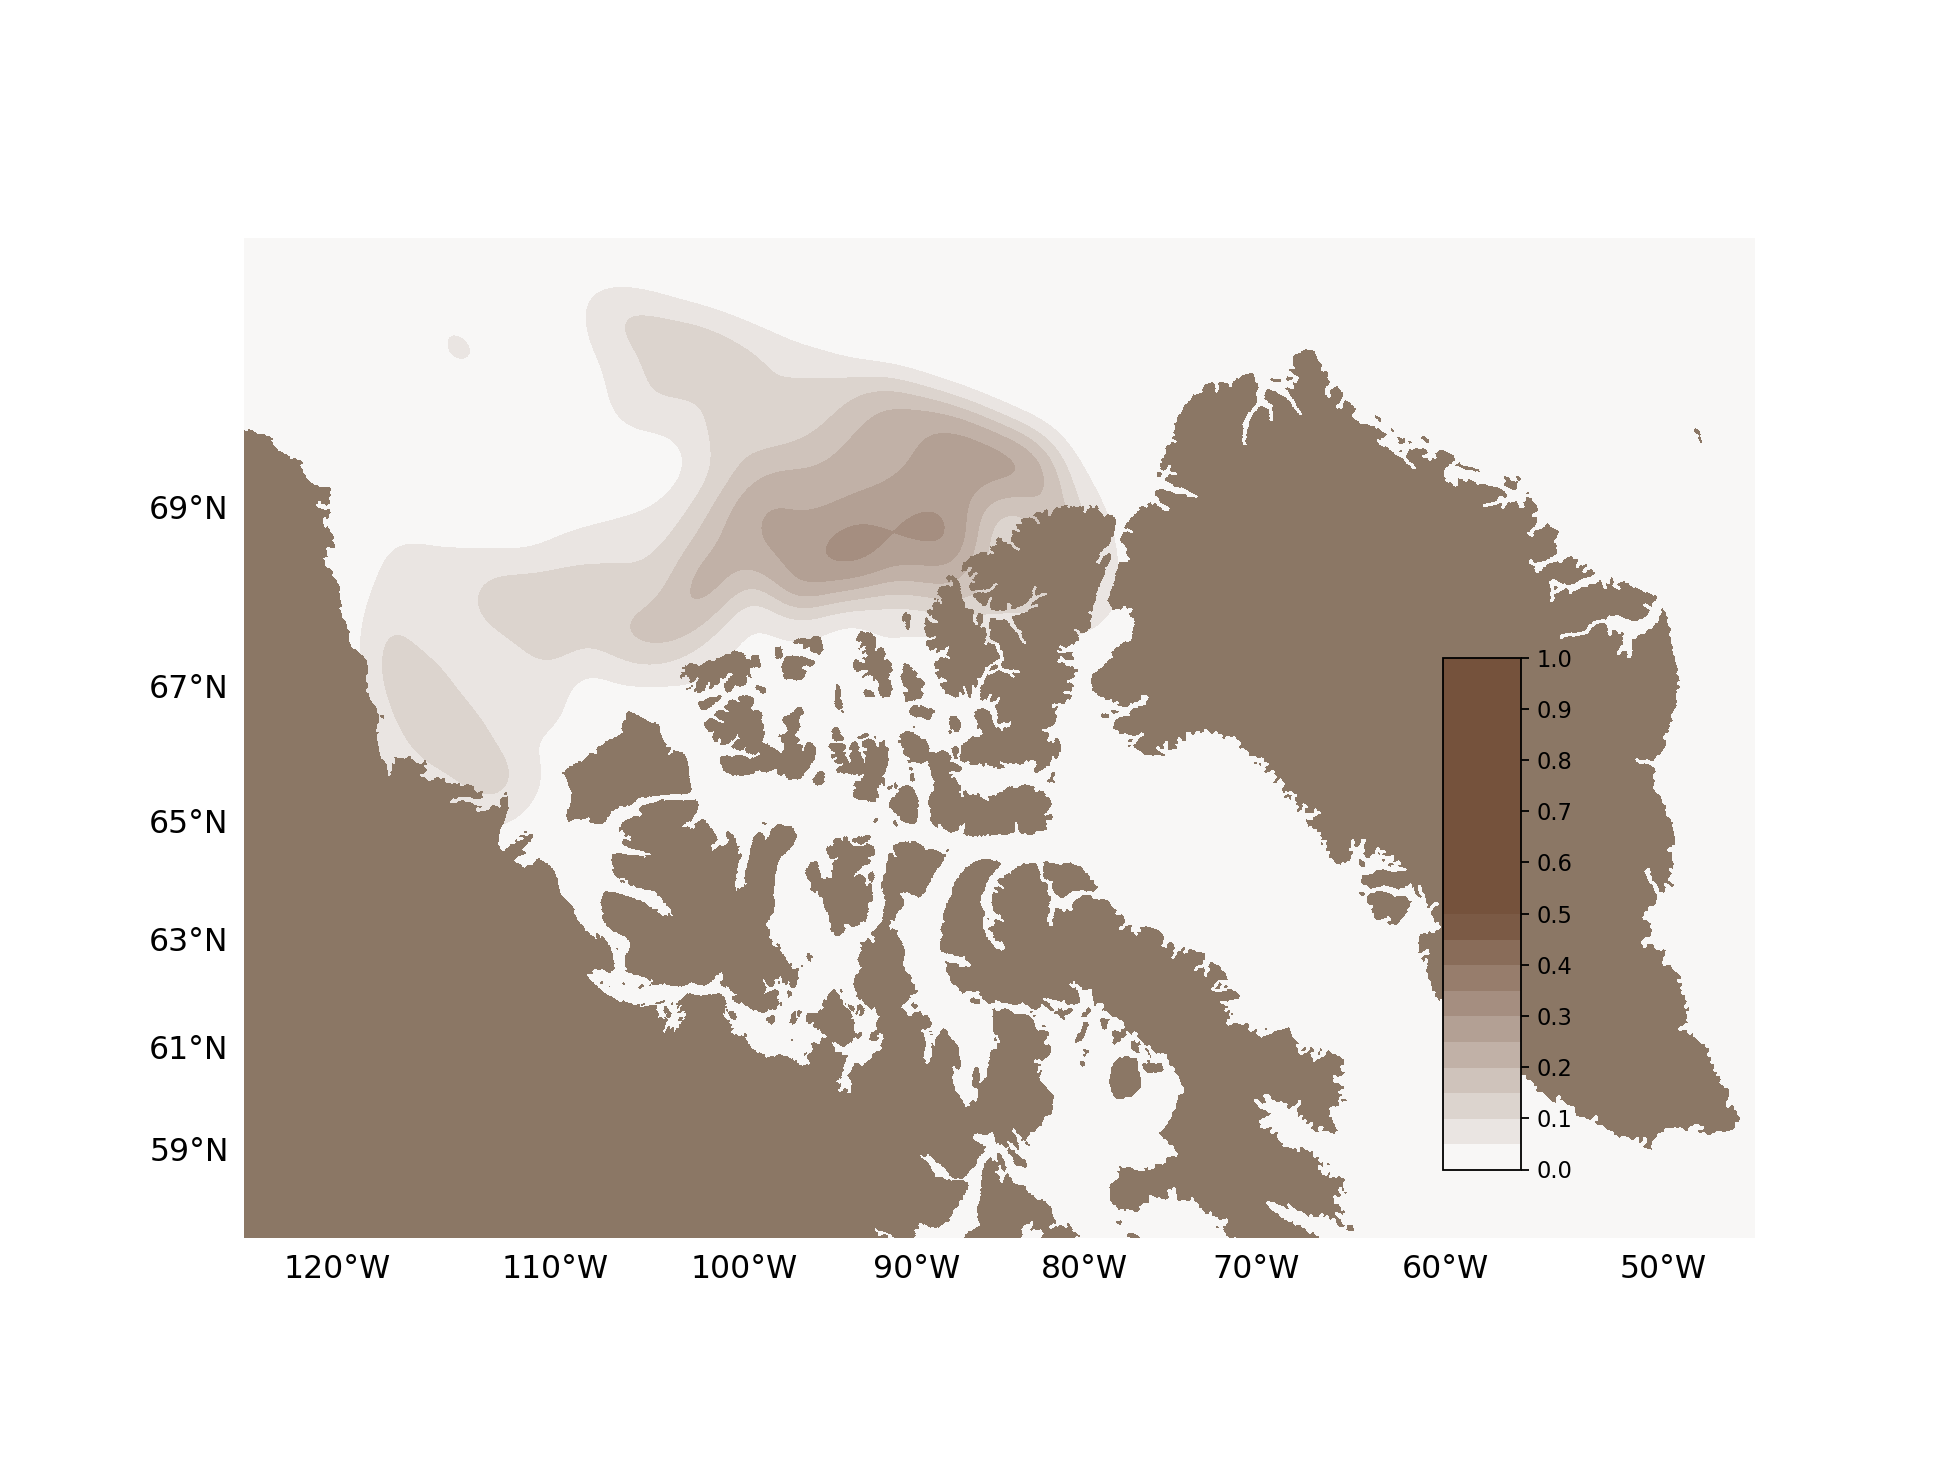

In [37]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

x_model, y_model = proj1(forcing_lons, forcing_lats)
CS1 = proj1.contourf(x_model, y_model, Z2, vmin=0, vmax=0.5, levels=np.arange(0,1.05,0.05), cmap=sed_cmap)


cbaxes1 = fig.add_axes([0.74, 0.20, 0.04, 0.35]) 
CB1 = plt.colorbar(CS1, cax=cbaxes1, ticks=np.arange(0,1.1,0.1))

save to forcing field:

In [39]:
c   = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12-EXH006_y2015m01d05_gridT.nc','r')

ncd = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ice_sediment-20200212.nc', 'w', zlib=True)
ncd.createDimension('x',len(c.dimensions['x']))
ncd.createDimension('y',len(c.dimensions['y']))

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 2400

In [40]:
# variables
nav_lat = ncd.createVariable('nav_lat', 'float32', ('y','x'))
nav_lat.long_name = 'Latitude'
nav_lat.units = 'degrees_north'
nav_lat[:] = mesh_lat

nav_lon = ncd.createVariable('nav_lon', 'float32', ('y','x'))
nav_lon.long_name = 'Longitude'
nav_lon.units = 'degrees_east'
nav_lon[:] = mesh_lon

mn_sed = ncd.createVariable('prop_sb', 'float32', ('y','x'))
mn_sed.units = 'none'
mn_sed.long_name = 'Proportion of siberian sediment in ice'  
mn_sed.coordinates = 'nav_lon nav_lat'
mn_sed[:] = Z2

In [41]:
ncd.close()